In [2]:
from numpy import save, load
from pandas import read_csv
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras import Model
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense,Activation
from keras.models import Input, Model
from keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,GlobalAveragePooling1D,TimeDistributed, MaxPooling1D
import tensorflow as tf
import numpy as np
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.layers import Activation, Lambda
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
x_train = np.load('gdrive/My Drive/d1/trainX.npy')
y_train = np.load('gdrive/My Drive/d1/trainy.npy')
x_test = np.load('gdrive/My Drive/d1/testX.npy')
y_test = np.load('gdrive/My Drive/d1/testy.npy')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(33104, 128, 6) (33104, 118) (3740, 128, 6) (3740, 118)


In [4]:

from sklearn.model_selection import LeaveOneOut
#idx = np.random.permutation(len(x_train))
#x_train = x_train[idx]
#y_train = y_train[idx]
#from sklearn.model_selection import train_test_split
#x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
cv = LeaveOneOut()
for train_idx , val_idx in cv.split(x_train):
  X_train, X_val = x_train[train_idx], x_train[val_idx]
  Y_train, Y_val = y_train[train_idx], y_train[val_idx]

In [5]:
X_train.shape

(33103, 6, 128)

In [6]:
def channel_normalization(x):
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out

def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x

In [7]:
class TCN:

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding
        
        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

In [8]:
input_shape = X_train.shape[1:]
input = Input(shape=X_train.shape[1:])
x = SpatialDropout1D(0.2)(input)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc1')(x)
x = TCN(128,dilations = [1, 2, 4, 8, 16],kernel_size = 3, return_sequences=True, name = 'tnc2')(x)
max_pool = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(max_pool)
x = Dropout(0.2)(x)
output = Dense(118, activation="softmax")(x)    
model = Model(inputs=input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 6, 128)      0           ['input_1[0][0]']                
 out1D)                                                                                           
                                                                                                  
 tnc1_initial_conv (Conv1D)     (None, 6, 128)       16512       ['spatial_dropout1d[0][0]']      
                                                                                                  
 tnc1_dilated_conv_1_tanh_s0 (C  (None, 6, 128)      49280       ['tnc1_initial_conv[0][0]']  

In [9]:
history = model.fit(X_train, Y_train, epochs=200, verbose=True, validation_data=(X_val, Y_val), batch_size=128,callbacks=callbacks)


Epoch 1/200
259/259 [==============================] - 51s 185ms/step - loss: 1.8603 - accuracy: 0.5648 - val_loss: 0.0270 - val_accuracy: 1.0000
Epoch 2/200
259/259 [==============================] - 49s 191ms/step - loss: 0.5227 - accuracy: 0.8668 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 3/200
259/259 [==============================] - 48s 187ms/step - loss: 0.3659 - accuracy: 0.9040 - val_loss: 2.1300e-04 - val_accuracy: 1.0000
Epoch 4/200
259/259 [==============================] - 49s 188ms/step - loss: 0.2983 - accuracy: 0.9206 - val_loss: 1.4435e-04 - val_accuracy: 1.0000
Epoch 5/200
259/259 [==============================] - 49s 188ms/step - loss: 0.2488 - accuracy: 0.9316 - val_loss: 8.0100e-04 - val_accuracy: 1.0000
Epoch 6/200
259/259 [==============================] - 48s 186ms/step - loss: 0.2163 - accuracy: 0.9391 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/200
259/259 [==============================] - 48s 184ms/step - loss: 0.1854 - accuracy: 0.9463 - val_lo

In [10]:
loss, accuracy = model.evaluate(X_val, Y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  1.0000
Testing Accuracy: 0.8826


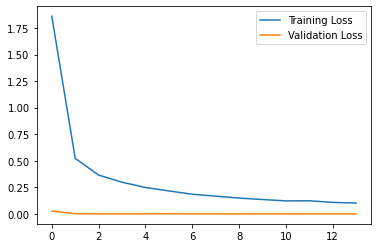

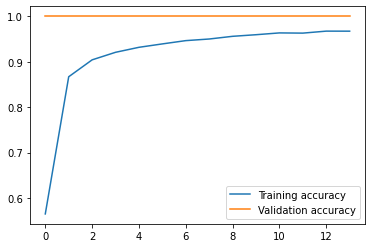

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()